<a href="https://colab.research.google.com/github/LukeHaberkamp/tensorflow-timeseries-essentials/blob/main/D_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook trains a neural network to classify a timeseries as either stable or unstable

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

Using the logistic equation to generate timeseries data

In [ ]:
def logisticEq(r, x0, N):
    x = [x0]
    for i in range(1, N):
        x_new = r * x[i-1] * (1 - x[i-1])
        x.append(x_new)
    return np.array(x)

Generate the sample data. With the logistic growth equation, we will generate one chaotic timeseries (r=4) and one stable timeseries (r=3.5)

In [ ]:
samples = np.arange(0, 10000)

r1 = 3.5
r2 = 4
x0 = 0.3
N = len(samples)

y1 = logisticEq(r=r1, x0=x0, N = N) * 5
y1 = np.expand_dims(y1, axis=1) # add dimension to define 1D data

y2 = logisticEq(r=r2, x0=x0, N = N) * 5
y2 = np.expand_dims(y2, axis=1) # add dimension to define 1D data

Functions to embed the data and plot for visualization of the phase portrait

In [ ]:
def TDE(x, m, tau):
    emb = np.zeros((len(x)-m*tau, m))
    for i in range(m):
        emb[:,i] = x[i*tau:(i*tau + (len(x)-m*tau))]
    return emb

In [ ]:
def statespaceplot(x, title):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    if x.shape[1] > 2:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], alpha=0.7)
    else:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("X'")
    ax.set_zlabel('X"')
    plt.show()

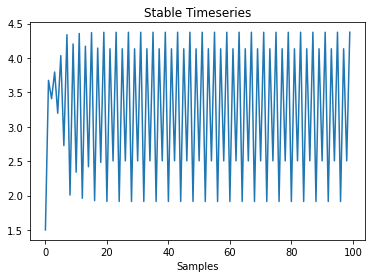

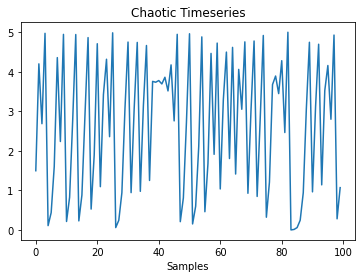

In [ ]:
plt.plot(samples[:100], y1[:100])
plt.xlabel("Samples")
plt.title("Stable Timeseries")
plt.show()

plt.plot(samples[:100], y2[:100])
plt.xlabel("Samples")
plt.title("Chaotic Timeseries")
plt.show()

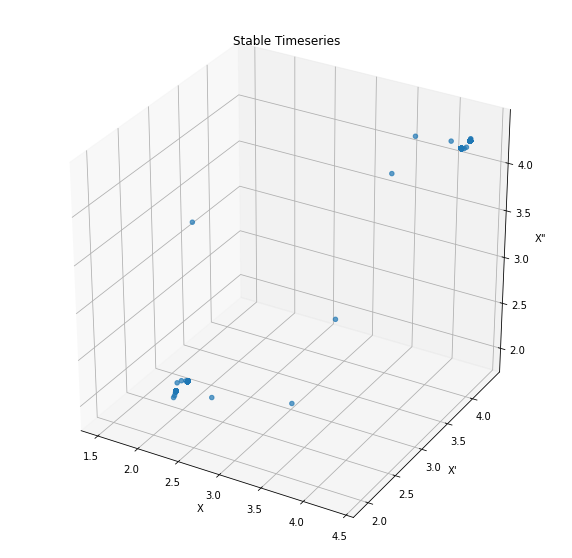

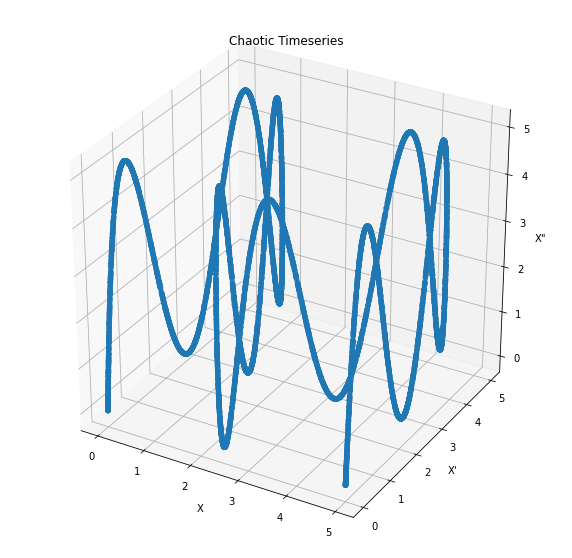

In [ ]:
y1_tde_data = TDE(y1.squeeze(), m=3, tau=2)
statespaceplot(y1_tde_data, "Stable Timeseries")

y2_tde_data = TDE(y2.squeeze(), m=3, tau=2)
statespaceplot(y2_tde_data, "Chaotic Timeseries")

To prevent vanishing/expoding gradients we scale the data before into the network. StandardScaler (x - mean / std) or MinMaxScaler ((x - min) / (max - min)) work well. This is crucial for multivariate datasets.
  
We are using MinMaxScaler 

In [ ]:
scaler = MinMaxScaler()
scaled_y1 = scaler.fit_transform(y1)
scaled_y2 = scaler.transform(y2)

"createsequence" is a function to window the data to create model inputs with a corresponding label 

In [ ]:
def createsequences(data, label, window_size=32):
    x = []
    y = []
    for i in range(window_size, data.shape[0]):
        x.append(data[i-window_size:i])
        y.append(label)

    return np.array(x), np.array(y)

Window the data and use an numeric label of 0 for stable data and 1 for unstable timeseries

In [ ]:
stable_x, stable_y = createsequences(scaled_y1, label=0)
unstable_x, unstable_y = createsequences(scaled_y2, label=1)

x_data = np.concatenate([stable_x, unstable_x], axis=0)
y_data = np.concatenate([stable_y, unstable_y], axis=0)

x_data, y_data = shuffle(x_data, y_data)

In [ ]:
# check number of labels in our training outputs
len(np.unique(y_data))

2

Split the data into training and validation

In [ ]:
cutoff = round(0.8 * x_data.shape[0])

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_val = x_data[cutoff:]
y_val = y_data[cutoff:]

print("Training Inputs Shape:", x_train.shape)
print("Training Outputs Shape:", y_train.shape)

print("\nValidation Inputs Shape:", x_val.shape)
print("Validation Outputs Shape:", y_val.shape)

Training Inputs Shape: (15949, 32, 1)
Training Outputs Shape: (15949,)

Validation Inputs Shape: (3987, 32, 1)
Validation Outputs Shape: (3987,)


Put data into a tensorflow dataset. I need to do this when I don't have enough RAM on my machine
This is not necessary, just will come in handy one day.

In [ ]:
batch_size = 32
shuffle_buffer_size = 1000

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(batch_size=batch_size)
train_ds = train_ds.shuffle(shuffle_buffer_size).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size=batch_size)
val_ds = val_ds.shuffle(shuffle_buffer_size).prefetch(1)

Create a LSTM Model. Note that the sigmoid activation is added to the output layer for the binary classification problem.

In [ ]:
inputs = Input(shape=(None, 1))

h = LSTM(16, return_sequences=True)(inputs)
h = LSTM(16, return_sequences=False)(h)

outputs = Dense(1, activation='sigmoid')(h)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Compile and train the model. Use binary crossentropy loss for our classification problem

In [ ]:
optimizer = Adam(learning_rate=1e-3)
metrics = 'acc'
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=20,
            shuffle=True,
            batch_size=32,
            verbose=1)

Epoch 1/20
499/499 [==============================] - 22s 22ms/step - loss: 0.1237 - acc: 0.9492 - val_loss: 0.0204 - val_acc: 0.9965
Epoch 2/20
499/499 [==============================] - 9s 17ms/step - loss: 0.0289 - acc: 0.9942 - val_loss: 0.0167 - val_acc: 0.9977
Epoch 3/20
499/499 [==============================] - 9s 17ms/step - loss: 0.0215 - acc: 0.9954 - val_loss: 0.0144 - val_acc: 0.9965
Epoch 4/20
499/499 [==============================] - 8s 17ms/step - loss: 0.0176 - acc: 0.9964 - val_loss: 0.0149 - val_acc: 0.9962
Epoch 5/20
499/499 [==============================] - 9s 17ms/step - loss: 0.0210 - acc: 0.9955 - val_loss: 0.1724 - val_acc: 0.9506
Epoch 6/20
499/499 [==============================] - 9s 18ms/step - loss: 0.0247 - acc: 0.9940 - val_loss: 0.0113 - val_acc: 0.9980
Epoch 7/20
499/499 [==============================] - 9s 17ms/step - loss: 0.0239 - acc: 0.9940 - val_loss: 0.0278 - val_acc: 0.9920
Epoch 8/20
499/499 [==============================] - 9s 17ms/step -

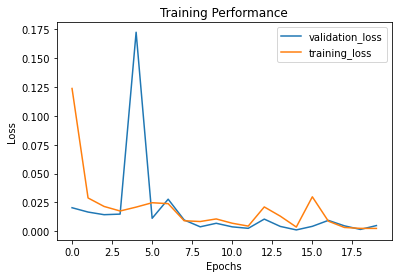

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate the validation dataset

In [ ]:
y_pred = model.predict(x_val, batch_size=32)

125/125 [==============================] - 1s 4ms/step


In [ ]:
# Raw outputs for the model predictions
print(y_pred)

[[1.584601e-04]
 [9.999789e-01]
 [1.584601e-04]
 ...
 [9.999729e-01]
 [1.584601e-04]
 [9.999691e-01]]


The model outputs values on a scale from 0 to 1. It is necessary to threshold these values and assign a classification value ( 0 or 1 ). I'm using 0.5 as my threshold.

In [ ]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(y_pred)

[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]


Evaluate the accuracy of our model's prediction on the validation data

In [ ]:
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred) * 100
print("Accuracy =", round(accuracy, 3))

Accuracy = 99.875
